In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [2]:
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import email
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
stop_words = set(stopwords.words('english'))
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
%autosave 60

Autosaving every 60 seconds


# Spam Email Classification

### Importing the data
     
The raw dataset, as supplied, is separated into two categories: Ham and Spam.

In [4]:
hamdir = r'C:\Users\Checkout\Downloads\Compressed\Ham Unprocessed'
spamdir = r'C:\Users\Checkout\Downloads\Compressed\Spam Unprocessed'
dirs=[hamdir,spamdir]

def count_dirs(dirs):
    for d in dirs:
        folders = 0
        for _, dirnames, filenames in os.walk(d):
          # ^ this  means "we won't be using this value"
            folders += len(dirnames)
        print('There are',folders,'folders in the Ham Directory')

count_dirs(dirs)

There are 249 folders in the Ham Directory
There are 34 folders in the Ham Directory


In [5]:
def getlist(directory):
    # this function takes the directory name, iterates over each file subdirectories
    # and appends them to the list 'mylist'
    mylist=[]
    for directory, subdirectory, filenames in  os.walk(directory):
        for filename in filenames:
            with open(os.path.join(directory, filename), "r",encoding="latin-1") as f:
                data = f.read()
             
            # the below code checks for multi part emails and appends them to 'mylist'
            b = email.message_from_string(data)
            if b.is_multipart():
                for payload in b.get_payload():
                    if payload.is_multipart():
                        for payload1 in payload.get_payload():
                            mylist.append(payload1.get_payload())
                    else:        
                        mylist.append(payload.get_payload())
            else:
                mylist.append(b.get_payload())

    return mylist

In [6]:
# sending the ham and spam directories to the getlist function
# this will return a list of emails 

hamlist=getlist(hamdir)
spamlist=getlist(spamdir)

### Organizing the data
     
Once both Ham and Spam lists have been created, they will be combined into a pandas dataframe which will allow for simple manipulation during cleaning stage.

In [7]:
def create_df(hamlist,spamlist):
    
    # takes both ham and spam lists and concatenated them into a dataframe
    # returns dataframe once complete

    # create dataframe of ham
    ham=pd.DataFrame(hamlist,columns =['email'])
    # add target column for ham
    ham['target']=0
    
    # do same process for spam
    spam=pd.DataFrame(spamlist,columns =['email'])
    spam['target']=1
    #concatenate ham and spam and shuffle dataframe
    all_emails=pd.concat([ham,spam])
    all_emails = all_emails.sample(frac=1).reset_index(drop=True)

    
    return all_emails

In [8]:
# send the newly created ham list and spam list to the create_df function
# this will return a new dataframe which will be saved as 'all_emails'

all_emails = create_df(hamlist,spamlist)

### Cleaning the Data

Regular expressions suitable for these email files were created and will be used on each message.

Lemmatizing is a technique which essentially truncates words to their base form.

Stop words such as **'the, a, an, in'** are words of little importance and unneccesary for processing task.

Before the cleaning process, we will check a single row for noise such as punctuation, HTML tags or URLs and stop words. This can then be compared to the same email after the cleaning process.  

In [9]:
all_emails.head(5)

,email,target
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2//E...",1
1,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
2,"Dec. 21, 2000\nTeco Tap 0.000 / Enron ; 18.75...",0
3,\n\nStart Date: 2/7/02; HourAhead hour: 1; No...,0
4,bm9iZWxtdXNldW1Abm9iZWwuc2UNCm1ib3VjaGFyZEBtdX...,1


In [10]:
def clean_regex(m):
        
        #defining the cleaning function which will run several regex search & replace
        # processes on each email
        # m for message in email column
        m = re.sub(r'^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$','',str(m)) # email addresses
        m = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+', ' ', str(m)) # http/url regex
        m = re.sub(r'\d+', '', str(m)) # numbers
        m = re.sub(r'<[^<]+?>', '', str(m)) # html <tags>
        m = m.replace(r'[^a-zA-Z]', '') # non alphanumerics
        m = m.replace('nbsp', '') # common in unprocessed spam files, new html
        m = m.translate(str.maketrans('', '', punctuation)) # remove punctuation
        m = m.lower() # lower case

        return m
    
def clean_column(df,col_name):
    
    # apply clean regex to column
    df[col_name]=df[col_name].apply(clean_regex)
    
    # apply stop word removal to column
    df[col_name]=df[col_name].apply(lambda x: ' '.join([item for item in x.split() if item not in stop_words]))
    
    # keep only words between 3 and 15 characters long (some very long gibberish strings in some emails)
    df[col_name]=df[col_name].apply(lambda x: ' '.join([item for item in x.split() if 3 <= len(item) <= 15]))
    
    # initialize Lemmatizer
    lem = WordNetLemmatizer()
    
    # apply verb lemmatizer
    df[col_name]=df[col_name].apply(lambda x: ' '.join([lem.lemmatize(word,pos='v') for word in x.split()]))

    # apply noun lemmatizer
    df[col_name]=df[col_name].apply(lambda x: ' '.join([lem.lemmatize(word,pos='n') for word in x.split()]))
    
    return df

In [11]:
# send all_emails dataset to clean_column function
# arguments are:  dataset, column to clean

all_emails_clean = clean_column(all_emails,'email')

The whole column of emails should now be cleaned, so the same row as before can be printed to observe the results. 

In [12]:
all_emails_clean.head(5)

,email,target
0,richard also send hey man real college girl li...,1
1,message bundle offer limit stock pentium foron...,1
2,dec teco tap enron hpl gas daily dec teco tap ...,0
3,start date hourahead hour ancillary schedule a...,0
4,,1


### Resampling Data 

The dataset must be split into two segments: a training set and test set for use in model training. The models will be trained on the training set, and validated using the test data as 'unseen' data.

In [13]:
# check value counts before sample 
s=all_emails.target.value_counts()

print('There are',s.values[0],'spam emails and',s.values[1],'ham emails in the dataset')

There are 41032 spam emails and 19088 ham emails in the dataset


In [14]:
def downsamp_maj(df,target):

    # this function can be used for downsampling the majority class to match the minority class 
    # this function works for any panda dataframe with two classes labeled 0 and 1
    # arguents: panadas dataframe and response variable column name as string
    
    # get counts of both classes
    lenclass_1 = len(df[df[target]==1])
    lenclass_0 = len(df[df[target]==0])

    # if class 1 is larger than class 0
    if lenclass_1 > lenclass_0:

        # set class 1 as the majority and class 0 as minority
        df_majority = df[df[target]==1]
        df_minority = df[df[target]==0]
        
        # downsample majority to the number of classes in minority
        df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=lenclass_0,     # to match minority class
                                 random_state=123) # reproducible results 

        # join downsampled majortiy and minority into dataframe
        df = pd.concat([df_majority_downsampled, df_minority],ignore_index=True)
        
    # otherwise downsample class 0
    else:

        df_majority = df[df[target]==0]
        df_minority = df[df[target]==1]

        df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=lenclass_1,     # to match minority class
                                 random_state=123) # reproducible results 

        # Combine minority class with downsampled majority class
        df = pd.concat([df_majority_downsampled, df_minority],ignore_index=True)

    return df

In [15]:
# send the email dataset to the function downsamp_maj which takes the dataframe, and the name of the column
# containing the class labels, in this case the name is 'target'

balanced_emails = downsamp_maj(all_emails,'target')

# get value counts for printout
s=balanced_emails.target.value_counts()
print('There are',s.values[0],'spam emails and',s.values[1],'ham emails in the dataset')

There are 19088 spam emails and 19088 ham emails in the dataset


### Data Visualization

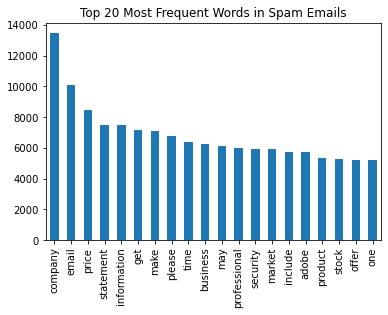

In [16]:
top_spam = pd.Series(' '.join(balanced_emails['email'][balanced_emails['target']==1]).split()).value_counts()[:20]
top_spam.plot(kind='bar')
plt.title('Top 20 Most Frequent Words in Spam Emails')
plt.show()


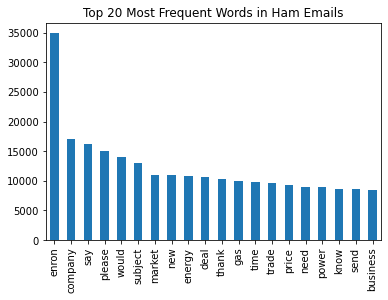

In [17]:
top_ham = pd.Series(' '.join(balanced_emails['email'][balanced_emails['target']==0]).split()).value_counts()[:20]
top_ham.plot(kind='bar')
plt.title('Top 20 Most Frequent Words in Ham Emails')
plt.show()

### Train Test Split

We will be splitting the data 70/30 ie. 70% of the data will be used for training, and 30% for evaluation.

In [18]:
def tt_split(df):
    
    xtrain, xtest, ytrain, ytest = train_test_split(df['email'], df['target'], test_size=0.3,random_state=5)
    
    return xtrain,xtest,ytrain,ytest

xtrain,xtest,ytrain,ytest = tt_split(balanced_emails)

### Feature Extraction with TFID Transformer

In order to train the models with the email data, it will need to be converted to numerical format. One useful method is to transform the data using sklearn's TFID Transformer. TFID stands for *'Term Frequency Inverse Document'*. Term Frequency records the number of times a word appears in a document to the total number of words in that document. The more times a word increases in each document, the higher the ratio or term frequency of that word. Each document has its own term frequency ratio.

In [19]:
def tfid_vec(train,test):
    
    # initialize vectorizer - we will check ngrams up to length 2
    transformer = TfidfVectorizer(ngram_range=(1,2),min_df=5)
    
    # using the vectorizer to transform the training and test data to numerical values.  
    train_tfid = transformer.fit_transform(train)
    test_tfid = transformer.transform(test)
    
    return train_tfid,test_tfid

xtrain_tfid,xtest_tfid = tfid_vec(xtrain,xtest)

### Model Training and Evaluation

In [20]:
# Multinomial Naive Bayes
mymodelNB = MultinomialNB().fit(xtrain_tfid, ytrain)

#K Nearest Neightbours
mymodelKNN = KNeighborsClassifier().fit(xtrain_tfid,ytrain)

#Decision Tree
mymodelDT= tree.DecisionTreeClassifier().fit(xtrain_tfid,ytrain)

# Random Forest
mymodelRF = RandomForestClassifier().fit(xtrain_tfid, ytrain)

# Logistic Regression
mymodelLR = LogisticRegression().fit(xtrain_tfid,ytrain)

In [21]:
def plot_matrix(ytest,ypreds,classes,title):
    # Code adapted and tweaked from scikit-learn.org

    cm=confusion_matrix(ytest, ypreds,labels=[1,0])
  
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [22]:
def evaluate_model(model,xtest,ytest):
    
    # get class predictions
    ypreds=model.predict(xtest)
    
    # get class probabilities for use in ROC curve
    yprobs=model.predict_proba(xtest)[:,1]
    
    # set model name
    model_name = type(model).__name__
    
    print('\n---------',model_name,'---------\n')
    
    # accuracy score
    score = metrics.accuracy_score(ytest, ypreds, normalize=True, sample_weight=None)
    print('\n\nAcruacy score of ',score)
    
    # call plot_matrix function 
    classes=['spam','ham']
    plt.figure()
    plot_matrix(ytest,ypreds,classes,model_name)
    
    # classification report

    print(metrics.classification_report(ytest, ypreds,target_names=['Spam','Ham']))
    
    # Compute false positive rate, true positive rate, thresholds and area under the ROC curve
    fpr, tpr, thresholds = roc_curve(ytest, yprobs)
    roc_auc = roc_auc_score(ytest, yprobs)
    
    plt.figure()
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.legend(loc="best")
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('ROC '+model_name)
    
    return score,model_name

Now that the functions have been set up, each trained model can be passed into the **evaluate_model** function, with accuracy recorded in a results list.


--------- MultinomialNB ---------



Acruacy score of  0.9402776565092116
              precision    recall  f1-score   support

        Spam       0.90      0.99      0.94      5712
         Ham       0.99      0.89      0.94      5741

    accuracy                           0.94     11453
   macro avg       0.94      0.94      0.94     11453
weighted avg       0.94      0.94      0.94     11453



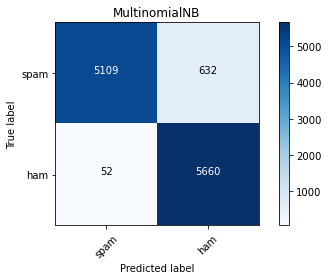

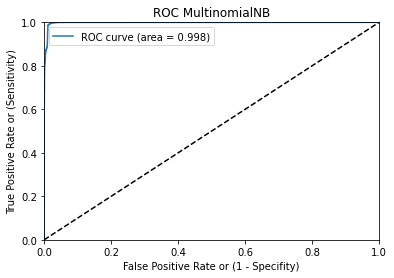

In [23]:
#Multinomial Naive Bayes Performance Metrics

results=[]

score,model_name=evaluate_model(mymodelNB,xtest_tfid,ytest)

results.append((model_name,score))


--------- KNeighborsClassifier ---------



Acruacy score of  0.6379987776128525
              precision    recall  f1-score   support

        Spam       1.00      0.27      0.43      5712
         Ham       0.58      1.00      0.73      5741

    accuracy                           0.64     11453
   macro avg       0.79      0.64      0.58     11453
weighted avg       0.79      0.64      0.58     11453



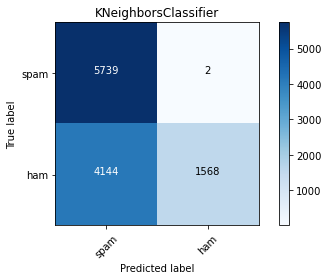

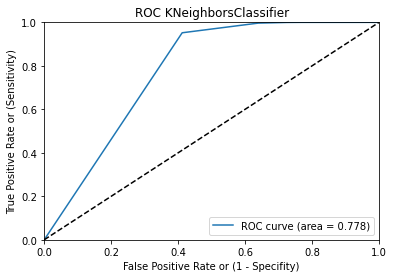

In [24]:
#K Nearest Neighbours Performance Metrics

score, model_name = evaluate_model(mymodelKNN,xtest_tfid,ytest)

results.append((model_name,score))


--------- DecisionTreeClassifier ---------



Acruacy score of  0.954073168602113
              precision    recall  f1-score   support

        Spam       0.95      0.96      0.95      5712
         Ham       0.96      0.95      0.95      5741

    accuracy                           0.95     11453
   macro avg       0.95      0.95      0.95     11453
weighted avg       0.95      0.95      0.95     11453



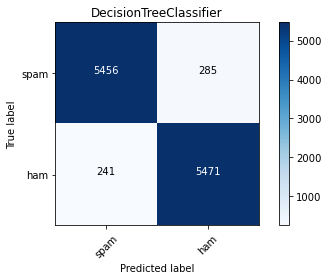

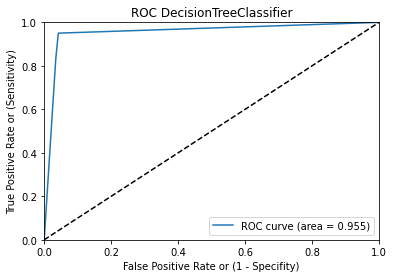

In [25]:
#Decision Tree Performance Metrics

score,model_name = evaluate_model(mymodelDT,xtest_tfid,ytest)

results.append((model_name,score))


--------- RandomForestClassifier ---------



Acruacy score of  0.9811403125818563
              precision    recall  f1-score   support

        Spam       0.98      0.98      0.98      5712
         Ham       0.98      0.98      0.98      5741

    accuracy                           0.98     11453
   macro avg       0.98      0.98      0.98     11453
weighted avg       0.98      0.98      0.98     11453



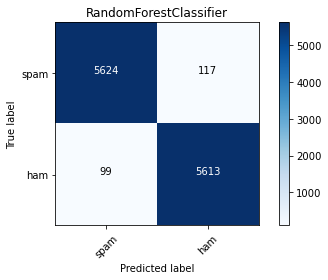

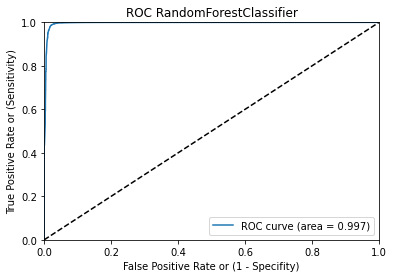

In [26]:
#Random Forest Performance Metrics**

score,model_name = evaluate_model(mymodelRF,xtest_tfid,ytest)

results.append((model_name,score))


--------- LogisticRegression ---------



Acruacy score of  0.9830612066707413
              precision    recall  f1-score   support

        Spam       1.00      0.97      0.98      5712
         Ham       0.97      1.00      0.98      5741

    accuracy                           0.98     11453
   macro avg       0.98      0.98      0.98     11453
weighted avg       0.98      0.98      0.98     11453



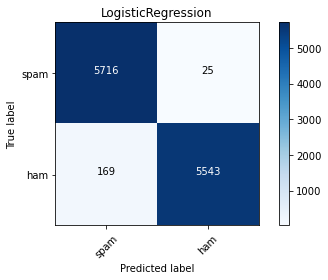

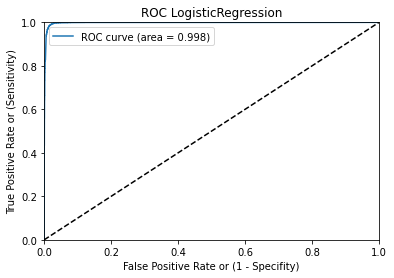

In [27]:
#Logistic Regression Performance Metrics

score,model_name = evaluate_model(mymodelLR,xtest_tfid,ytest)

results.append((model_name,score))

In [28]:
for name,score in results:
    print(name,round(score,4))

MultinomialNB 0.9403
KNeighborsClassifier 0.638
DecisionTreeClassifier 0.9541
RandomForestClassifier 0.9811
LogisticRegression 0.9831


## Model Selection and Fine Tuning

The above list of accuracy scores shows that **Logistic Regression** is the highest performing model in terms of accuracy rate. Indeed it also has a very good AUC (Area under ROC curve).

In [29]:
grid_params = {"C":[0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty":["l1","l2"]}
log_grid  = LogisticRegression()
mymodelLR_Grid = GridSearchCV(log_grid,param_grid=grid_params,cv=10,n_jobs=-1)
mymodelLR_Grid = mymodelLR_Grid.fit(xtrain_tfid,ytrain)
print("Best hpyerparameters : ",mymodelLR_Grid.best_params_)
print("Accuracy :",mymodelLR_Grid.best_score_)

Best hpyerparameters :  {'C': 1000, 'penalty': 'l2'}
Accuracy : 0.9878005912977637


C:\Users\Checkout\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The values C = 1000 and Penalty = L2 were chosen as the best parameters. This new logistic regression model will now be used on the test data to ascertain if the performance has increased. It will be initialized as 'best_LR', and sent to the  **evaluate_model** function.


--------- LogisticRegression ---------



Acruacy score of  0.9889985156727495
              precision    recall  f1-score   support

        Spam       1.00      0.98      0.99      5712
         Ham       0.98      1.00      0.99      5741

    accuracy                           0.99     11453
   macro avg       0.99      0.99      0.99     11453
weighted avg       0.99      0.99      0.99     11453



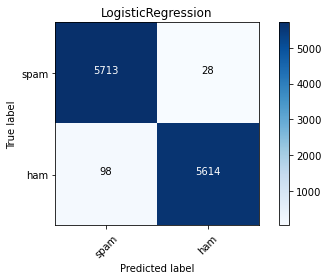

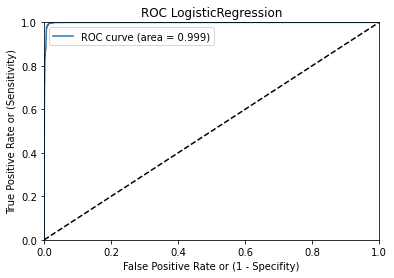

In [30]:
best_LR = mymodelLR_Grid.best_estimator_
score,model_name = evaluate_model(best_LR,xtest_tfid,ytest)

As we can see, these new parameters have boosted the accuracy score of the Logistic Regression model. The model can now be saved using the pickle library for later use.

In [31]:
import pickle

# save the model to disk

filename = 'Best_Model_LogiRegression.sav'
pickle.dump(best_LR, open(filename, 'wb'))


## Conclusion

From the various models created in this project, the Logistic Regression model came out on top, followed closely by Multinomial Naive Bayes. It might be difficult to improve this model more - perhaps more training data would be useful to increase the accuracy rate. Roughly 20,000 'ham' emails were removed to balance the dataset. It is yet to be seen whether upsampling the 'spam' emails would improve or worsen the results.

